In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from model import *

In [2]:
import pandas as pd 

df = pd.read_csv("prices_all_1m.csv")
n = len(df)
startingRow = 0

In [3]:
#paramaters for SIMULATION

# APY's
lendRate = .00
borrowRate = .00
farmRate = .3

#SIM INFO
stepsPerYear = 365*24*60 #if simulating hourly set to be 365 * 24 

annualRates = {'lend' : lendRate, 'borrow' : borrowRate, 'farm' : farmRate}
adjRates = {'lend' : ((1 + lendRate)**(1/stepsPerYear) - 1), 
            'borrow' : ((1 + borrowRate)**(1/stepsPerYear) - 1),
            'farm' : (farmRate / stepsPerYear)}

In [4]:
#SIM HELPERS
def setInitialValues() :
    vol1 = volume1
    vol2 = volume2 
    lp = createLp(vaultToken, secondaryToken, vol1, vol2)
    vaultInitial = createVault(vaultTVL, lendAllocation, vaultToken, secondaryToken, vol1, vol2)
    return vol1, vol2, lp, vaultInitial

def genSimulatedTrades() : 
    allTrades = []

    for i in range(nSteps) : 
        tradeStep = genTradesRandom(lambdaTrades, expScale, pBuy)
        allTrades.append(tradeStep)
    return allTrades

def simStats(vaultTVL, vaultLog) : 
    apy = (vaultLog[-1] / vaultTVL)**(stepsPerYear / nSteps) - 1
    dradown = 0
    prevMax = vaultTVL
    for i in range(len(vaultLog)) : 
        prevMax = max(prevMax, vaultLog[i])
        drawdownT = 1 - vaultLog[i] / prevMax
        drawdown = max(dradown, drawdownT)
    return apy, drawdown


In [5]:
from random import random
from random import randrange


vaultTVL = 1000.
lendAllocation = .5
vaultToken = 'USDC'
secondaryToken = 'ETH'
n = len(df)
startingRow = randrange(int(0.5*n))
startingPrice = df['Close_' + secondaryToken][startingRow]
#LP Size 
volume1 =  2000000 #amount of vaultToken in LP
volume2 =  volume1 / startingPrice #amount of secondary token in LP

priceData = list(df['Close_' + secondaryToken][startingRow:])



In [6]:
debtLow = .98
debtHigh = 1.02

collatLow = .5
collatTarget = .55
collatHigh = .6

vol1, vol2, lp, vaultInitial = setInitialValues()
vaultLog, priceLog, debtRatioLog, collatRatioLog, vol1, vol2 = simulateMarket(priceData, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates,
                                                            collatLow = collatLow, collatTarget = collatTarget, collatHigh = collatHigh, 
                                                            debtLow = debtLow, debtHigh = debtHigh)


In [7]:
from scipy.stats import sem
from random import random

nFwd = 3 * 60 
nBack = 30 
nLags = 10

# baseline given slippage for rebalances 
priceDrop = 1 - .1*0.004

pLog = .2

n = len(priceData) - nFwd - nBack*(2**(nLags-1))

seList = []
returnList = []

for j in range(nLags) : 
    seList.append([])

for j in range(n) : 
    if (random() < pLog) : 
        startInd = j + nBack*(2**(nLags-1))
        endInd = startInd + nFwd
        returnList.append( vaultLog[endInd] / vaultLog[startInd])
        
        for k in range(nLags) : 
            lagInd = startInd - nBack * (2**k)
            seList[k].append(sem(priceData[lagInd : startInd]))
            
            


In [8]:
priceDrop = 1 - 1 / 10000

data = pd.DataFrame(returnList, columns = ['fwdRet'], dtype = float)
data['priceDrop'] = data.apply(lambda row : row.fwdRet <= priceDrop, axis = 1)

for j in range(nLags) : 
    data['seLag' + str(j)] = seList[j]


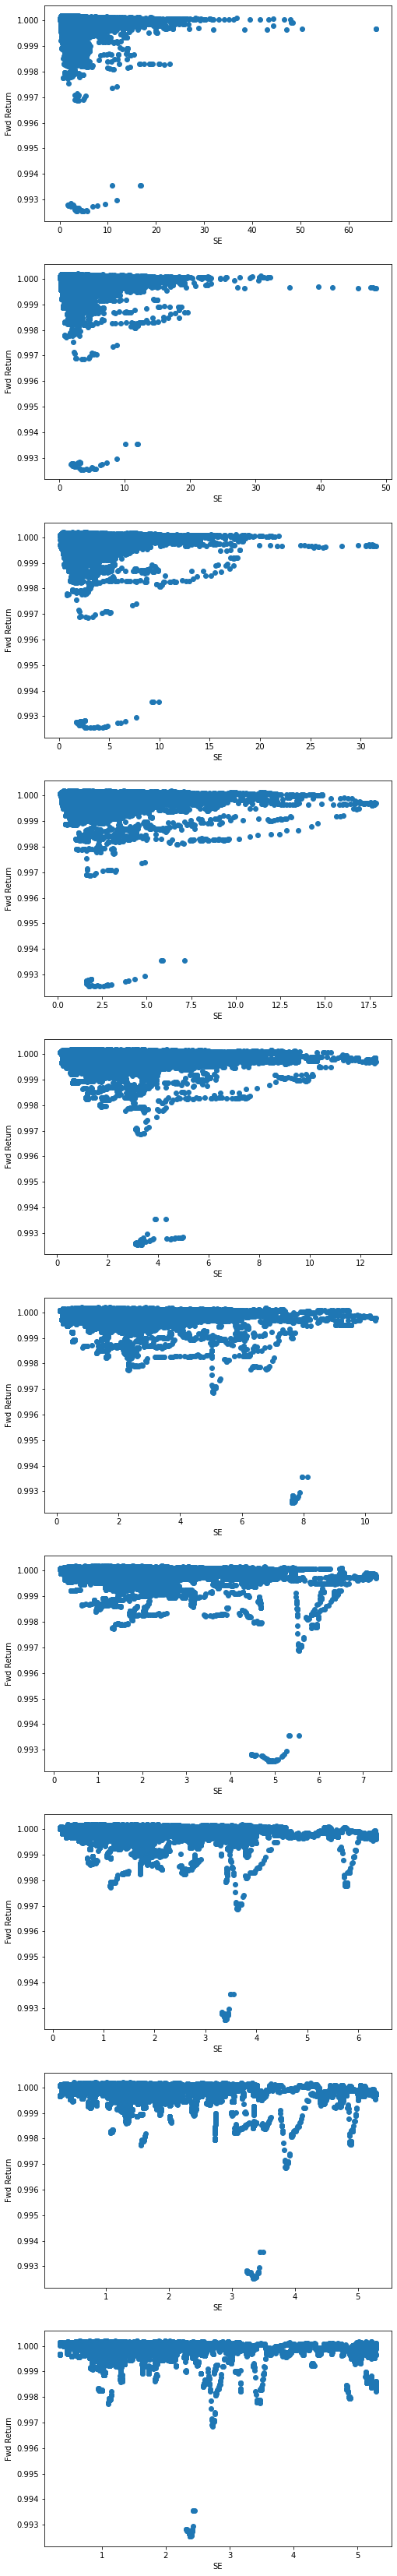

In [9]:
fig = plt.figure()
fig.set_size_inches(8,6*nLags)

#fig.subplots_adjust(hspace=1, wspace=1)

for j in range(nLags):

    ax = fig.add_subplot(nLags, 1, j+1)
    ax.set_ylabel('Fwd Return')
    ax.set_xlabel('SE')
    plt.scatter(seList[j], returnList, label = "")


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


preds = []
for j in range(nLags) : 

    preds.append('seLag' + str(j))
    
data = data.dropna(subset = preds)

    
X_train, X_test, y_train, y_test = train_test_split(data[preds], 
                                                    data['priceDrop'], test_size=0.4,
                                                    shuffle = True)

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [15]:
predictions = logmodel.predict(X_test)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.90      0.99      0.95     43725
        True       0.66      0.09      0.16      5217

    accuracy                           0.90     48942
   macro avg       0.78      0.54      0.55     48942
weighted avg       0.88      0.90      0.86     48942



In [17]:
retRaw = 1
retPred = 1 

for i in range(len(X_test)) : 
    ind = y_test.index[i]
    pred = predictions[i]
    
    retRaw = retRaw*returnList[ind]
    
    if pred == False: 
        retPred = retPred*returnList[ind]

In [20]:
retPred / retRaw

1.3703405483943532

In [18]:
import torch

l1 = 32
l2 = 16

model = torch.nn.Sequential(
    #torch.nn.BatchNorm1d(960, affine=True),
    torch.nn.Linear(10,l1),
    torch.nn.BatchNorm1d(l1, affine=True),
    torch.nn.ReLU(),

    
    #torch.nn.Dropout(.2),
    torch.nn.Linear(l1,l2),
    torch.nn.BatchNorm1d(l2, affine=True),
    torch.nn.ReLU(),

    #torch.nn.Dropout(.2),
    torch.nn.Linear(l2,1)
    )

def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

criterion = RMSELoss
#loss_fn = criterion(yhat,y)

loss_fn = torch.nn.MSELoss(reduction = 'mean')

In [15]:
data

,fwdRet,priceDrop,seLag0,seLag1,seLag2,seLag3,seLag4,seLag5,seLag6,seLag7,seLag8,seLag9
0,1.000076,False,0.449961,0.306278,0.255426,0.593330,0.359281,0.563454,0.868341,0.703961,0.701503,0.641074
1,1.000075,False,0.452233,0.295718,0.246882,0.587090,0.359140,0.553253,0.868256,0.703686,0.701149,0.641060
2,1.000076,False,0.420010,0.290103,0.227822,0.575643,0.358811,0.531613,0.868059,0.703126,0.700422,0.641033
3,1.000075,False,0.396595,0.268514,0.219623,0.550336,0.358555,0.446358,0.867687,0.701572,0.698074,0.640945
4,1.000077,False,0.341366,0.275160,0.219211,0.527785,0.358064,0.393961,0.867722,0.700726,0.696868,0.640918
...,...,...,...,...,...,...,...,...,...,...,...,...
117852,1.000082,False,0.827424,0.822795,1.153822,1.516077,1.942647,1.533026,1.557543,1.502060,1.961279,1.388722
117853,1.000088,False,0.753238,0.822407,1.110926,1.497445,1.937065,1.532933,1.555814,1.501965,1.960929,1.388867
117854,1.000078,False,0.753770,0.821677,0.763757,1.352929,1.901888,1.532262,1.543468,1.501340,1.958499,1.389871
117855,1.000091,False,0.894113,0.831323,0.706350,1.294901,1.877113,1.532000,1.538171,1.501125,1.957505,1.390313


In [21]:
import torch.utils.data as data_utils

X_train, X_test, y_train, y_test = train_test_split(data[preds], 
                                                    data['fwdRet'], test_size=0.4,
                                                    shuffle = True)

# Creating np arrays
target = torch.tensor((y_train*1).values)
features = torch.tensor(X_train.values)

# Passing to DataLoader
train = data_utils.TensorDataset(features, target)
train_loader = data_utils.DataLoader(train, batch_size=3, shuffle=True)

test_target = torch.tensor((y_test*1).values)
test_features = torch.tensor(X_test.values)

In [22]:
preds

['seLag0',
 'seLag1',
 'seLag2',
 'seLag3',
 'seLag4',
 'seLag5',
 'seLag6',
 'seLag7',
 'seLag8',
 'seLag9']

In [23]:
learning_rate = 0.1
n_epochs = 5
t = 1
for i in range(n_epochs) :
      print("EPOCH " + str(i))
      for train_data in train_loader : 
            x = train_data[0]
            y = train_data[1]
            y_pred = model(x.float())
            #loss = criterion(y_pred, y.float())
            
            loss = loss_fn(y_pred, y.float())
            
            if t % 1000 == 0:
                print(t, loss.item())
            
            model.zero_grad()
            loss.backward()

            t+=1

            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad

      with torch.no_grad(): 
          test_pred = model(test_features.float())
          test_loss = criterion(test_pred, test_target.float())
          print("Valid RMSE = " + str(test_loss.item()))


EPOCH 0


/home/matt/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1000 4.3828571506310254e-05
2000 1.580085609020898e-07
3000 9.446941895419059e-09
4000 9.915672727345282e-09
5000 8.496717218697825e-10
6000 9.092114616748859e-09
7000 6.446147615690734e-09
8000 4.7590211771364466e-09
9000 2.383326203059255e-09
10000 6.855758183377247e-10
11000 7.174361105199978e-09
12000 7.14073822294381e-09
13000 1.0196654187666354e-08
14000 1.3085115213584686e-08
15000 1.2266053062148785e-08
16000 1.6203216546273325e-10
17000 9.55642120992195e-10
18000 1.531630100526371e-10
19000 3.43944321912204e-08
20000 1.1014643641615862e-09
21000 1.6430759330887668e-07
22000 8.241613613790832e-09
23000 5.856790963321146e-08
24000 4.623154081784264e-10


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 32])